In [9]:
from utils import OptimizedChirpsDownloader
import ee

In [10]:
# ========= 1) Autenticación =========
def ee_init_interactive(project_id: str | None = None):
    try:
        ee.Initialize(project=project_id) if project_id else ee.Initialize()
    except Exception:
        ee.Authenticate()
        ee.Initialize(project=project_id) if project_id else ee.Initialize()

ee_init_interactive('ee-diegoagudelo30-2')

## Example for download daily data for multiple points since 1982 until 2024

In [ ]:
downloader1 = OptimizedChirpsDownloader(output_dir="./chirps_optimized")

downloader1.download_chirps_optimized(
    points=((-74.1, 4.6), (-75.5, 6.2), (-72.5, 3.4)),
    years=[1981, 2024],
    window_mmdd=['01-01', '12-31'],
    temp_target='daily',
    temp_agg='sum',
    scale=5000
)


📍 POINT MODE: downloading point time series as long table
✅ Point time series (daily) saved to: chirps_optimized\chirps_points_daily_1981_2024.csv


WindowsPath('chirps_optimized/chirps_points_daily_1981_2024.csv')

In [13]:
import pandas as pd 

data = pd.read_csv('./chirps_optimized/chirps_points_daily_1981_2024.csv')
print(data.head())

   point_id   lon  lat        date    precip
0         0 -74.1  4.6  1981-01-01  4.669996
1         1 -75.5  6.2  1981-01-01  0.000000
2         2 -72.5  3.4  1981-01-01  2.976952
3         0 -74.1  4.6  1981-01-02  0.000000
4         1 -75.5  6.2  1981-01-02  4.618917


## Example for download monthly data for multiple points since 1982 until 2024

In [14]:
downloader1 = OptimizedChirpsDownloader(output_dir="./chirps_optimized")

downloader1.download_chirps_optimized(
    points=((-74.1, 4.6), (-75.5, 6.2), (-72.5, 3.4)),
    years=[1981, 2024],
    window_mmdd=['01-01', '12-31'],
    temp_target='monthly',
    temp_agg='sum',
    scale=5000
)


📍 POINT MODE: downloading point time series as long table
✅ Point time series (monthly) saved to: chirps_optimized\chirps_points_monthly_1981_2024.csv


WindowsPath('chirps_optimized/chirps_points_monthly_1981_2024.csv')

In [15]:
import pandas as pd 

data = pd.read_csv('./chirps_optimized/chirps_points_monthly_1981_2024.csv')
print(data.head())

   point_id   lon  lat     date     precip
0         0 -74.1  4.6  1981-01  14.617618
1         1 -75.5  6.2  1981-01  18.176682
2         2 -72.5  3.4  1981-01  12.974985
3         0 -74.1  4.6  1981-02  36.093081
4         1 -75.5  6.2  1981-02  58.144918


## Example for spatial data by country

In [16]:
downloader = OptimizedChirpsDownloader(output_dir="./chirps_optimized")

# ========== DESCARGA OPTIMIZADA ==========

# CASO 1: Datos diarios históricos largos
downloader.download_chirps_optimized(
    shape="Kenya",
    years=[1982, 1985],  # 5 años = ~1,825 imágenes
    window_mmdd=['01-01', '12-31'],  # Todo el año
    temp_target='daily',
    temp_agg='sum',  # No aplica para daily
    scale=5000,
    max_workers=3  # 3 descargas paralelas
)


🚀 OPTIMIZED CHIRPS DOWNLOAD WITH STACKS

📅 Total images: 1461
   Range: 1982-01-01 → 1985-12-31

📊 Estimating download capacity...
   Estimated size per image: 0.03 MB

📦 Stack configuration:
   Images per stack: 50
   Estimated size per stack: 1.34 MB
   Total stacks: 30
   Parallel workers: 3
   Period per stack: ~1 months

💾 Total estimated size: 0.04 GB

⬇️  STARTING DOWNLOAD
✓ Stack stack_0001_19820101_to_19820219 (1/30) - 6.1s
✓ Stack stack_0002_19820220_to_19820410 (2/30) - 7.2s
✓ Stack stack_0003_19820411_to_19820530 (3/30) - 8.4s
✓ Stack stack_0004_19820531_to_19820719 (4/30) - 6.3s
✓ Stack stack_0005_19820720_to_19820907 (5/30) - 5.9s
✓ Stack stack_0006_19820908_to_19821027 (6/30) - 5.8s
✓ Stack stack_0008_19821217_to_19830204 (8/30) - 5.0s
✓ Stack stack_0007_19821028_to_19821216 (7/30) - 8.0s
✓ Stack stack_0009_19830205_to_19830326 (9/30) - 6.2s
✓ Stack stack_0010_19830327_to_19830515 (10/30) - 7.3s
✓ Stack stack_0011_19830516_to_19830704 (11/30) - 5.2s
✓ Stack stack_0012_1


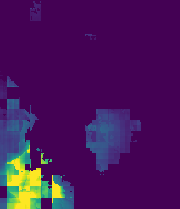

In [45]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import folium
from folium.raster_layers import ImageOverlay

tif_path = r"D:\OneDrive - CGIAR\Desktop\codigos_dengue\claude_agwise\chirps_optimized\tiffs\stack_0001_19820101_to_19820219.tif"
band_index = 1

with rasterio.open(tif_path) as src:
    band = src.read(band_index).astype(float)
    bounds = src.bounds
    nodata = src.nodata

if nodata is not None:
    band = np.ma.masked_equal(band, nodata)
else:
    band = np.ma.masked_less_equal(band, -9000)

valid = band.compressed()
vmin = np.percentile(valid, 2)
vmax = np.percentile(valid, 98)

norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("viridis")  # 👈 aquí el cambio

rgba = cmap(norm(band.filled(vmin)))
rgba_uint8 = (rgba * 255).astype(np.uint8)

center_lat = (bounds.top + bounds.bottom) / 2
center_lon = (bounds.left + bounds.right) / 2

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles="OpenStreetMap"
)

img_overlay = ImageOverlay(
    name="CHIRPS",
    image=rgba_uint8,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
)
img_overlay.add_to(m)

folium.Marker(
    location=[center_lat, center_lon],
    popup="Center of CHIRPS TIFF"
).add_to(m)

folium.LayerControl().add_to(m)

m